## [Vision Transformer (ViT)](https://arxiv.org/pdf/2010.11929v2.pdf)

The Vision Transformer (ViT) is a transformer targeted at vision processing tasks. It has achieved state-of-the-art performance in image classification and (with some modification) other tasks. The ViT concept for image classification is as follows:

<img src="./figures/vit.gif" title="ViT" />

### How does ViT work?

The steps of ViT are as follows:

1. Split input image into patches
2. Flatten the patches
3. Produce linear embeddings from the flattened patches
4. Add position embeddings
5. Feed the sequence preceeded by a `[class]` token as input to a standard transformer encoder
6. Pretrain the model to ouptut image labels for the `[class]` token (fully supervised on a huge dataset such as ImageNet-22K)
7. Fine-tune on the downstream dataset for the specific image classification task

### ViT architecture

ViT is a Transformer encoder. In detail, it looks like this:

<img src="./figures/ViTArchitecture.png" title="ViT architecture" />

In the figure we see four main parts:
<ol style="list-style-type:lower-alpha">
    <li> The high-level architecture of the model.</li>
    <li> The Transformer module.</li>
    <li> The multiscale self-attention (MSA) head.</li>
    <li> An individual self-attention (SA) head.</li>
</ol>

In [1]:
import os
# Set GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
import torch
import torch.nn as nn
import numpy as np
import time
import math

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

from tqdm.auto import tqdm

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('Using device', device)

Using device cpu


/Users/guntsv/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
from torch.utils.data import random_split

# Loading data
transform = ToTensor()

full_dataset = MNIST(root='../Lightning/', train=True, download=True, transform=transform)
# Define the sizes for the training and validation sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
val_size = len(full_dataset) - train_size   # 20% for validation

# Split the dataset into training and validation sets
train_set, val_set = random_split(full_dataset, [train_size, val_size])
test_set = MNIST(root='../Lightning/', train=False, download=True, transform=transform)
test_set = MNIST(root='../Lightning/', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=16)
val_loader = DataLoader(val_set, shuffle=False, batch_size=16)
test_loader = DataLoader(test_set, shuffle=False, batch_size=16)

### Multi-head Self Attention (MSA) Model

As with the basic transformer above, to build the ViT model, we need to create a MSA module and put it
together with the other elements.

For a single image, self attention means that each patch's representation
is updated based on its input token's similarity with those of the other patches.
As before, we perform a linear mapping of each patch to three distinct vectors $q$, $k$, and $v$ (query, key, value).

For each patch, we need to compute the dot product of its $q$ vector with all of the $k$ vectors, divide by the square root of the dimension
of the vectors, then apply softmax to the result. The resulting matrix is called the matrix of attention cues.
We multiply the attention cues with the $v$ vectors associated with the different input tokens and sum them all up.

The input for each patch is transformed to a new value based on its similarity (after the linear mapping to $q$, $k$, and $v$) with other patches.

However, the whole procedure is carried out $H$ times on $H$ sub-vectors of our current 8-dimensional patches, where $H$ is the number of heads.

Once all results are obtained, they are concatenated together then passed through a linear layer.

The MSA model looks like this:

In [4]:
class MSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        self.k_mappings = [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        self.v_mappings = [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

### Position encoding

The position encoding allows the model to understand where each patch is in the original image. While it is theoretically possible to learn
such positional embeddings, the original Vaswani et al. Transformer uses a fixed position embedding representation that adds
low-frequency values to the first dimension and higher-frequency values to the later dimensions, resulting in a code that is
more similar for nearby tokens than far away tokens. For each token, we add to its j-th coordinate the value

$$ p_{i,j} =
\left\{\begin{matrix}
\sin (\frac{i}{10000^{j/d_{embdim}}})\\ 
\cos (\frac{i}{10000^{j/d_{embdim}}})
\end{matrix}\right.
$$

We can visualize the position encoding matrix thusly:

<img src="img/peimages.png" title="" style="width: 800px;" />

Here is an implementation:

In [5]:
def get_positional_embeddings(sequence_length, d, device="cpu"):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result.to(device)

## ViT Model
Create the ViT model as below. The explaination is later.

The MLP contains two layers with a GELU non-linearity.

$\bf{z}_0 = [\bf{x}_\text{class}; \, \bf{x}^1_p \bf{E}; \, \bf{x}^2_p \bf{E}; \cdots; \, \bf{x}^{N}_p \bf{E}] + \bf{E}_{pos}, \bf{E} \in \mathbb{R}^{(P^2 \cdot C) \times D} , \bf{E}_{pos}  \in \mathbb{R}^{(N + 1) \times D} $

$\bf{z^\prime}_\ell = \operatorname{MSA}(\operatorname{LN}(\bf{z}_{\ell-1})) + \bf{z}_{\ell-1}, \ell=1\ldots L $

$\bf{z}_\ell = \operatorname{MLP}(\operatorname{LN}(\bf{z^\prime}_{\ell})) + \bf{z^\prime}_{\ell}, \ell=1\ldots L $

$\bf{y} = \operatorname{LN}(\bf{z}_L^0)$

In [6]:
class ViT(nn.Module):
    def __init__(self, input_shape, n_patches=7, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(ViT, self).__init__()

        # Input and patches sizes
        self.input_shape = input_shape
        self.n_patches = n_patches
        self.n_heads = n_heads
        assert input_shape[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert input_shape[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (input_shape[1] / n_patches, input_shape[2] / n_patches)
        self.hidden_d = hidden_d

        # 1) Linear mapper
        self.input_d = int(input_shape[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        # (In forward method)

        # 4a) Layer normalization 1
        self.ln1 = nn.LayerNorm((self.n_patches ** 2 + 1, self.hidden_d))

        # 4b) Multi-head Self Attention (MSA) and classification token
        self.msa = MSA(self.hidden_d, n_heads)

        # 5a) Layer normalization 2
        self.ln2 = nn.LayerNorm((self.n_patches ** 2 + 1, self.hidden_d))

    # 5b) Encoder MLP
        self.enc_mlp = nn.Sequential(
            nn.Linear(self.hidden_d, self.hidden_d),
            nn.ReLU()
        )

        # 6) Classification MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, w, h = images.shape
        patches = images.reshape(n, self.n_patches ** 2, self.input_d)

        # Running linear layer for tokenization
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

        # Adding positional embedding
        tokens += get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d, device).repeat(n, 1, 1)

        # TRANSFORMER ENCODER BEGINS ###################################
        # NOTICE: MULTIPLE ENCODER BLOCKS CAN BE STACKED TOGETHER ######
        # Running Layer Normalization, MSA and residual connection
        self.msa(self.ln1(tokens.to("cpu")).to(device))
        out = tokens + self.msa(self.ln1(tokens))

        # Running Layer Normalization, MLP and residual connection
        out = out + self.enc_mlp(self.ln2(out))
        # TRANSFORMER ENCODER ENDS   ###################################

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)

#### Step 1: Patchifying and the linear mapping

The transformer encoder was developed with sequence data in mind, such as English sentences. However, an image is not a sequence. Thus, we break it into multiple sub-images and map each sub-image to a vector.

We do so by simply reshaping our input, which has size $(N, C, H, W)$ (in our example $(N, 1, 28, 28)$), to size (N, #Patches, Patch dimensionality), where the dimensionality of a patch is adjusted accordingly.

In MNIST, we break each $(1, 28, 28)$ into 7x7 patches (hence, each of size 4x4). That is, we are going to obtain 7x7=49 sub-images out of a single image.

$$(N,1,28,28) \rightarrow (N,P\times P, H \times C/P  \times W \times C/P) \rightarrow (N, 7\times 7, 4\times 4) \rightarrow (N, 49, 16)$$

<img src="./figures/patch.png" title="an image is split into patches" />

#### Step 2: Adding the classification token

When information about all other tokens will be present here, we will be able to classify the image using only this special token. The initial value of the special token (the one fed to the transformer encoder) is a parameter of the model that needs to be learned.

We can now add a parameter to our model and convert our (N, 49, 8) tokens tensor to an (N, 50, 8) tensor (we add the special token to each sequence).

Passing from (N,49,8) → (N,50,8) is probably sub-optimal. Also, notice that the classification token is put as the first token of each sequence. This will be important to keep in mind when we will then retrieve the classification token to feed to the final MLP.

#### Step 3: Positional encoding

See above, as we mentioned.

#### Step 4: LN, MSA, and Residual Connection

The step is to apply layer normalization to the tokens, then apply MSA, and add a residual connection (add the input we had before applying LN).
- **Layer normalization** is a popular block that, given an input, subtracts its mean and divides by the standard deviation.
- **MSA**: same as the vanilla transformer.
- **A residual connection** consists in just adding the original input to the result of some computation. This, intuitively, allows a network to become more powerful while also preserving the set of possible functions that the model can approximate.

The residual connection is added at the original (N, 50, 8) tensor to the (N, 50, 8) obtained after LN and MSA.

#### Step 5: LN, MLP, and Residual Connection
All that is left to the transformer encoder is just a simple residual connection between what we already have and what we get after passing the current tensor through another LN and an MLP.

#### Step 6: Classification MLP
Finally, we can extract just the classification token (first token) out of our N sequences, and use each token to get N classifications.
Since we decided that each token is an 8-dimensional vector, and since we have 10 possible digits, we can implement the classification MLP as a simple 8x10 matrix, activated with the SoftMax function.

The output of our model is now an (N, 10) tensor.

In [7]:
model = ViT(
    input_shape=(1, 28, 28), 
    n_patches=7, 
    hidden_d=20, 
    n_heads=2, 
    out_d=10)

model = model.to(device)

In [8]:
model

ViT(
  (linear_mapper): Linear(in_features=16, out_features=20, bias=True)
  (ln1): LayerNorm((50, 20), eps=1e-05, elementwise_affine=True)
  (msa): MSA(
    (softmax): Softmax(dim=-1)
  )
  (ln2): LayerNorm((50, 20), eps=1e-05, elementwise_affine=True)
  (enc_mlp): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [9]:
import torch.optim as optim

num_epochs = 5
lr = 0.01

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = CrossEntropyLoss()

In [10]:
def train(model, train_loader, optimizer, criterion, device="cpu"):
    
    model.train()
    train_loss = 0.0
    train_correct, total = 0, 0

    for batch in tqdm(train_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        y_hat = model(x)
        loss = criterion(y_hat, y) / len(x)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_correct += torch.sum(torch.argmax(y_hat, dim=1) == y).item()
        total += len(x)

    return train_loss, train_correct/total

def evaluate(model, loader, criterion):

    model.eval()
    test_loss = 0.0
    test_correct, total = 0, 0
    
    for batch in tqdm(loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        y_hat = model(x)
        loss = criterion(y_hat, y) / len(x)
        test_loss += loss.item()

        test_correct += torch.sum(torch.argmax(y_hat, dim=1) == y).item()
        total += len(x)

    return test_loss, test_correct/total

In [11]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [12]:
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, test_acc = evaluate(model, val_loader, criterion)

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} | Test  Acc: {test_acc * 100:.2f}%')
    #lower perplexity is better

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 01 | Time: 0m 45s
	Train Loss: 329.664 | Train Acc: 70.44%
	 Val. Loss: 74.927 | Test  Acc: 86.62%


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 02 | Time: 0m 44s
	Train Loss: 295.282 | Train Acc: 88.73%
	 Val. Loss: 73.084 | Test  Acc: 90.32%


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 03 | Time: 0m 46s
	Train Loss: 292.464 | Train Acc: 90.20%
	 Val. Loss: 73.334 | Test  Acc: 89.64%


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 04 | Time: 0m 50s
	Train Loss: 291.517 | Train Acc: 90.64%
	 Val. Loss: 72.934 | Test  Acc: 90.53%


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 05 | Time: 0m 58s
	Train Loss: 290.619 | Train Acc: 91.14%
	 Val. Loss: 73.689 | Test  Acc: 88.96%


Text(0, 0.5, 'loss')

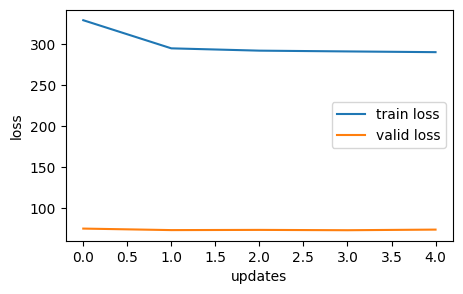

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [21]:
# model.load_state_dict(torch.load(save_path))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'\t Test. Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

	 Test. Loss: 60.827 | Test Acc: 90.40%
